# Interpretable model of morphological affixation

## The Problem

As speakers of a language, we have implicit knowledge of how words are built from parts. For example, English speaking children know how to form the plural by adding either an 's' sound (e.g., cats) or 'z' sound (e.g., dogs). Children show that they can utilize their implicit knowledge when they correctly produce the plural form given a nonsense word (e.g., wug --> wugs), even if they are unable to articulate that knowledge.

So, how is our knowledge of morphologically complex words structured? Do we have something like a dictionary entry for all root forms, plus rules for creating morphologically complex words from the roots (e.g., cat + add ‘s’; walk + add ‘ed’)? Or, do our neuronal connections act as a system of weighted associations that when given a root form, correctly produce the inflected form?

The first question is framed at a symbolic, rule-based level; representations of words and morphemes are stored as symbols, and are manipulated using rules. The second question is framed at a continuous, statistical level; representations of words and morphemes are patterns of neuronal activation, and statistical associations between these representations give rise to morphologically complex words.

Here, the interpretable model of morphological affixation seeks to unify the two levels, with a consistent interpretation across both. For example, this model relies on the use tensor product representations (TPRs), in which a vector representing a symbol (filler) is ‘bound’ to a vector representing a position (role) by taking the outer product of the two vectors. This network contains a TPR for the input stem, the output inflected form, and the morpheme, which is learned by the network over the course of training. Conceptually, these TPRs map onto the symbolic representations of the stem, inflected form, and morpheme as described at the symbolic level.

In its current state, the network can perform prefix, suffix, infix, interleaving, and single-symbol stem-change operations perfectly, given the stem and desired inflected form as training inputs. It also struggles to perform well on operations that are not found in natural languages, such as infixation after the middle symbol, and completely fails at others, such as string reversal. Shown here, the network can also take the stem and a set of morphological features as inputs, so that a single network can perform a morphological process with a variety of morphemes. For example, in Spanish verb inflection, the 1st person present tense morpheme is the –o suffix, while the 2nd person morpheme is the –as suffix (depending on the inflectional class of the verb). Many current state-of-the-art natural language processing models deal with this issue by concatenating the stem with a vector of morphological features, here it is done by passing both the stem and the morphological feature vectors in separate inputs.

In [126]:
import numpy as np
import re, sys
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
import time
import math

import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.autograd import Variable
from torch.nn.functional import log_softmax, relu6, sigmoid, linear
import torch.autograd as autograd

## Network Initializations

First, specify the number of filler symbols as `n_filler` and the number of roles as `n_role`. Here, we have 33 fillers, corresponding to the 31 letters, plus two word-edge symbols ('<' and '>'). The number of roles will vary depending on how long the stems and targets are.

`n_hidden` refers to the number of hidden units in the network. Here we have four, correspoinding to the indices for the stem/affix distinction, the position in the stem, the position in the affix, and the position in the output.

`n` refers to the total number of filler symbols, plus the five extra rows: `is_sym`, `is_begin`, `is_end`, `is_vowel`, and `is_cosonant`.


In [127]:
n_filler = 33 #26 letters, 2 word-edge symbols
n_hidden = 4
n_role = 22
n = n_filler+5

learning_rate = 0.002
n_iters = 5000

letters = '<abcdefghijklmnopqrstuvwxyzáíéóñ>'
vowels = 'aeiouáíéó'
consonants = 'bcdfghjklmnpqrstvwxyzñ'
symbols = {0:'<', 1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h',
           9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q',
           18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z',
           27:u'á', 28:u'í', 29:u'é', 30:u'ó', 31:u'ñ', 32:'>'}
sym_inv = {v: k for k, v in symbols.items()}

In this network, the use of tensor product representations allows for structured symbolic processing in a continuous, real-valued space. This model contains three tensor product representations: the stem, which is given to the model as input, the affix, which is learned over the course of training, the output, and the target output, which is used only during training.

The stem TPR is created by binding filler and role vectors. For each symbol in the stem, the filler vector for the corresponding symbol (e.g., `F[0]` for the start-of-word symbol ‘<’) and the role vector for the corresponding role (e.g., `R[0]` for the first position) are combined by the outer product [equation]. These outer products are then summed for each position. The stem TPR is the sum of these outer products, plus five additional rows indicating more abstract properties of the string being represented. These rows indicate whether there is a symbol in each position, whether the symbol is the start-of-word symbol, whether the symbol is the end-of-word symbol, whether the symbol is a vowel, and whether the symbol is a consonant.

The rest of the rows in `F` are random numbres drawn from a unifrom distribution between 0 and 2.

`R` is a `n_role` x `n_role` one-hot matrix, with each column corresponding to a role position. `U` is the transpose of the inverse of `R`, and will be used to unbind the filler symbol for a particular role.

In [128]:
F = Variable(torch.zeros(n,n_filler))
is_sym = Variable(torch.zeros(n_filler))
is_consonant = Variable(torch.zeros(n_filler))
is_vowel = Variable(torch.zeros(n_filler))
is_begin = Variable(torch.zeros(n_filler))
is_end = Variable(torch.zeros(n_filler))
for i in xrange(0,n_filler):
    is_sym[i] = 1
    if letters[i] == '<':
        is_begin[i] = 1
    if letters[i] == '>':
        is_end[i] = 1
    if letters[i] in vowels:
        is_vowel[i] = 1
    if letters[i] in consonants:
        is_consonant[i] = 1
F[0,:] = is_sym
F[1,:] = is_begin
F[2,:] = is_end
F[3,:] = is_vowel
F[4,:] = is_consonant
F[5:n,:] = Variable(torch.Tensor(n_filler,n_filler).uniform_(0,2))


R = Variable(torch.eye(n_role))
U = torch.inverse(torch.t(R))

## Defining functions

Below are some important functions:

`embed` takes in a filler and a role tensor, and returns the sum of the outer product of the each vector pair as an `n` x `n_role` tensor.

`rbf` returns a probability distribution over positions, using radial basis functions. This allows us scan through a tensor product representation to pick out the position we want to copy from. It is called inside of the network.

`get_indices` takes in a tensor product representation as input, and returns the indicies of the symbols that it represents. When we train the network, we need the indices of the target represenation.

`make_stem` takes a string as input, and returns the filler vectors that correspond to it.

`stringtostem` uses `make_stem` to take all input or target strings and return all corresponding stems.

`make_embeddings` uses `embed` to return all input or target tensor product representations given the stems and role tensor.

`decode` takes a tensor product representation as input and returns the readable string that it corresponds to. It is used to decode the output, and could also be used to decode the input or the learned affix.

In [129]:
def embed(filler,role):
    s = Variable(torch.zeros(n, n_role))
    for i in range(0,filler.shape[1]):
        s = s + torch.ger(filler[:,i],torch.t(role)[:,i])
    return s

def rbf(b, n, tau):
    mu = Variable(torch.arange(n),requires_grad=False).view(n,1)
    s = -(tau*torch.pow(b-mu,2))
    beta = torch.exp(log_softmax(s,dim=0))
    return beta

def get_indices(tpr):
    seq = Variable(torch.zeros(n_role).long())
    for t in xrange(0, n_role):
        f = torch.matmul(tpr,U[:,t]).unsqueeze(1)
        sse = torch.sum(torch.pow((F-f),2), dim=0)
        prob = torch.exp(log_softmax(-sse,dim=0))
        value, index = torch.max(prob,0)
        seq[t] = index
    return seq

def make_stem(string):
    stem = Variable(torch.zeros(n, len(string)))
    ind = [0]*n_role
    letters = list(string)
    for i in xrange(0,len(string)):
        ind[i] = sym_inv[letters[i]]
    for j in xrange(0,len(string)):
        stem[:,j] = F[:,ind[j]]
    return stem

def stringtostem(strings):
    stems = [0]*len(strings)
    for i in range(0,len(strings)):
        stems[i] = make_stem(strings[i][0])
    return stems

def stringtostem2(strings):
    stems = [0]*len(strings)
    for i in range(0,len(strings)):
        stems[i] = make_stem(strings[i])
    return stems

def make_embeddings(stems, R):
    input_tprs = [0]*len(stems)
    for i in range(0,len(stems)):
        S = embed(stems[i],R)
        input_tprs[i] = S
    return input_tprs

##### output decoder #####
def decode(Y):
    unfill = get_indices(Y)
    word = symbols[unfill.data[0]]
    for i in xrange(1, n_role):
        word = word + symbols[unfill.data[i]]
        if symbols[unfill.data[i]] == '>':
            break
    return word


## Create the inputs

Below is the stem embedding for the word 'kind', created using the `make_stem` function. Each column corresponds to a position in the stem.

In [130]:
print make_stem('<kind>')

Variable containing:
 1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
 1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  1.0000  0.0000  0.0000  1.0000
 0.0000  1.0000  0.0000  1.0000  1.0000  0.0000
 1.5415  0.5282  1.1394  1.9932  1.9940  1.9713
 1.2981  0.3494  0.6194  0.1665  1.3800  1.9871
 0.9601  1.2229  0.9074  1.4245  0.8851  1.5728
 0.1041  1.6313  1.0395  1.7830  0.4813  1.7471
 0.9388  1.5473  0.4394  0.5219  1.4321  0.5727
 1.4250  1.4230  1.5211  1.4357  0.1893  1.4547
 0.9366  0.0826  0.0027  0.7641  1.1146  0.0703
 1.9387  1.5625  0.9075  1.7449  0.1784  0.6147
 0.3649  1.5951  0.8191  0.6628  1.8286  1.2842
 0.3153  0.2352  1.1419  0.4694  1.3547  0.6528
 1.3061  1.1280  1.4155  0.6999  1.9410  1.2218
 1.6805  0.7668  1.1280  1.9077  1.6343  0.7713
 1.8455  0.9810  0.2555  0.1705  1.5697  1.5442
 0.5687  0.8752  0.8937  0.3402  1.3222  0.7074
 0.5100  1.2141  0.1380  1.0770  1.7796  0.5280
 0.3895  0.8951  1.

## Create the stimuli

Verb inflection in Spanish varies based on inflectional class. In Spanish, the inflectional class depends on the verb ending – a verb can be an –ar, –ir, or –er verb. Within each inflectional class, there are at least 60 different possible verb inflections. Spanish verb formation is highly regular, but many some of the most frequent verbs are (e.g., ser 'to be', ir 'to go'). Spanish also has some stem changing verbs, which typically have the form o–ue (e.g., dormir–duerme), e–ie (e.g., tener–tiene), or e–i (e.g., vestir–viste). 

The model currently is not built to handle irregular or stem-changing verbs, but could theoretically learn how to produce the correct outputs for a particular irregular verb if trained on it.

Below are all of the target verb inflections for four verb stems: hablar (to speak), cantar (to sing), bailar (to dance), and invitar (to invite). Each target contains the string itself, an index corresponding to the verb stem, and an index corresponding to the morphological feature embedding in `morph_embed` (below).

In [131]:
target_strings = [['<habla>',0,0],['<hablas>',0,1],['<habla>',0,2],['<hablamos>',0,3],[u'<habláis>',0,4],['<hablan>',0,5],
    ['<hable>',0,6],['<hables>',0,7],['<hable>',0,8],['<hablemos>',0,9],[u'<habléis>',0,10],['<hablen>',0,11],
    ['<hablaba>',0,12],['<hablabas>',0,13],['<hablaba>',0,14],[u'<hablábamos>',0,15],['<hablabais>',0,16],
    ['<hablaban>',0,17],[u'<hablaré>',0,18],[u'<hablarás>',0,19],[u'<hablará>',0,20],['<hablaremos>',0,21],
    [u'<hablaréis>',0,22],[u'<hablarán>',0,23],['<habla>',0,24],['<hable>',0,25],['<hablemos>',0,26],['<hablad>',0,27],
    ['<hablen>',0,28],['<hables>',0,29],['<hable>',0,30],['<hablemos>',0,31],[u'<habléis>',0,32],['<hablen>',0,33],
    [u'<hablaría>',0,34],[u'<hablarías>',0,35],[u'<hablaría>',0,36],[u'<hablaríamos>',0,37],[u'<hablaríais>',0,38],
    [u'<hablarían>',0,39],[u'<hablé>',0,40],['<hablaste>',0,41],[u'<habló>',0,42],['<hablamos>',0,43],['<hablasteis>',0,44],
    ['<hablaron>',0,45],['<hablara>',0,46],['<hablaras>',0,47],['<hablara>',0,48],[u'<habláramos>',0,49],['<hablarais>',0,50],
    ['<hablaran>',0,51],['<hablare>',0,52],['<hablares>',0,53],['<hablare>',0,54],[u'<habláremos>',0,55],['<hablareis>',0,56],
    ['<hablaren>',0,57],['<hablar>',0,58],['<hablado>',0,59],
    ['<canta>',1,0],['<cantas>',1,1],['<canta>',1,2],['<cantamos>',1,3],[u'<cantáis>',1,4],['<cantan>',1,5],['<cante>',1,6],
    ['<cantes>',1,7],['<cante>',1,8],['<cantemos>',1,9],[u'<cantéis>',1,10],['<canten>',1,11],['<cantaba>',1,12],
    ['<cantabas>',1,13],['<cantaba>',1,14],[u'<cantábamos>',1,15],['<cantabais>',1,16],['<cantaban>',1,17],[u'<cantaré>',1,18],
    [u'<cantarás>',1,19],[u'<cantará>',1,20],['<cantaremos>',1,21],[u'<cantaréis>',1,22],[u'<cantarán>',1,23],['<canta>',1,24],
    ['<cante>',1,25],['<cantemos>',1,26],['<cantad>',1,27],['<canten>',1,28],['<cantes>',1,29],['<cante>',1,30],['<cantemos>',1,31],
    [u'<cantéis>',1,32],['<canten>',1,33],[u'<cantaría>',1,34],[u'<cantarías>',1,35],[u'<cantaría>',1,36],[u'<cantaríamos>',1,37],
    [u'<cantaríais>',1,38],[u'<cantarían>',1,39],[u'<canté>',1,40],['<cantaste>',1,41],[u'<cantó>',1,42],['<cantamos>',1,43],
    ['<cantasteis>',1,44],['<cantaron>',1,45],['<cantara>',1,46],['<cantaras>',1,47],['<cantara>',1,48],[u'<cantáramos>',1,49],
    ['<cantarais>',1,50],['<cantaran>',1,51],['<cantare>',1,52],['<cantares>',1,53],['<cantare>',1,54],[u'<cantáremos>',1,55],
    ['<cantareis>',1,56],['<cantaren>',1,57],['<cantar>',1,58],['<cantado>',1,59],
    ['<baila>',2,0],['<bailas>',2,1],['<baila>',2,2],['<bailamos>',2,3],[u'<bailáis>',2,4],['<bailan>',2,5],['<baile>',2,6],
    ['<bailes>',2,7],['<baile>',2,8],['<bailemos>',2,9],[u'<bailéis>',2,10],['<bailen>',2,11],['<bailaba>',2,12],
    ['<bailabas>',2,13],['<bailaba>',2,14],[u'<bailábamos>',2,15],['<bailabais>',2,16],['<bailaban>',2,17],[u'<bailaré>',2,18],
    [u'<bailarás>',2,19],[u'<bailará>',2,20],['<bailaremos>',2,21],[u'<bailaréis>',2,22],[u'<bailarán>',2,23],['<baila>',2,24],
    ['<baile>',2,25],['<bailemos>',2,26],['<bailad>',2,27],['<bailen>',2,28],['<bailes>',2,29],['<baile>',2,30],
    ['<bailemos>',2,31],[u'<bailéis>',2,32],['<bailen>',2,33],[u'<bailaría>',2,34],[u'<bailarías>',2,35],[u'<bailaría>',2,36],
    [u'<bailaríamos>',2,37],[u'<bailaríais>',2,38],[u'<bailarían>',2,39],[u'<bailé>',2,40],['<bailaste>',2,41],[u'<bailó>',2,42],
    ['<bailamos>',2,43],['<bailasteis>',2,44],['<bailaron>',2,45],['<bailara>',2,46],['<bailaras>',2,47],['<bailara>',2,48],
    [u'<bailáramos>',2,49],['<bailarais>',2,50],['<bailaran>',2,51],['<bailare>',2,52],['<bailares>',2,53],['<bailare>',2,54],
    [u'<bailáremos>',2,55],['<bailareis>',2,56],['<bailaren>',2,57],['<bailar>',2,58],['<bailado>',2,59],
    ['<invita>',3,0],['<invitas>',3,1],['<invita>',3,2],['<invitamos>',3,3],[u'<invitáis>',3,4],['<invitan>',3,5],
    ['<invite>',3,6],['<invites>',3,7],['<invite>',3,8],['<invitemos>',3,9],[u'<invitéis>',3,10],['<inviten>',3,11],
    ['<invitaba>',3,12],['<invitabas>',3,13],['<invitaba>',3,14],[u'<invitábamos>',3,15],['<invitabais>',3,16],
    ['<invitaban>',3,17],[u'<invitaré>',3,18],[u'<invitarás>',3,19],[u'<invitará>',3,20],['<invitaremos>',3,21],
    [u'<invitaréis>',3,22],[u'<invitarán>',3,23],['<invita>',3,24],['<invite>',3,25],['<invitemos>',3,26],['<invitad>',3,27],
    ['<inviten>',3,28],['<invites>',3,29],['<invite>',3,30],['<invitemos>',3,31],[u'<invitéis>',3,32],['<inviten>',3,33],
    [u'<invitaría>',3,34],[u'<invitarías>',3,35],[u'<invitaría>',3,36],[u'<invitaríamos>',3,37],[u'<invitaríais>',3,38],
    [u'<invitarían>',3,39],[u'<invité>',3,40],['<invitaste>',3,41],[u'<invitó>',3,42],['<invitamos>',3,43],['<invitasteis>',3,44],
    ['<invitaron>',3,45],['<invitara>',3,46],['<invitaras>',3,47],['<invitara>',3,48],[u'<invitáramos>',3,49],['<invitarais>',3,50],
    ['<invitaran>',3,51],['<invitare>',3,52],['<invitares>',3,53],['<invitare>',3,54],[u'<invitáremos>',3,55],['<invitareis>',3,56],
    ['<invitaren>',3,57],['<invitar>',3,58],['<invitado>',3,59]]

Here I am only using four stems as a demonstration, but the model can be scaled up to all of the regular -ar verbs.

In [132]:
stems = stringtostem2(['<hablar>', '<cantar>','<bailar>', '<invitar>'])

The test and training sets are created by randomly breaking up the set of stimuli into two parts, 80% for the training set, and 20% for the test set.

In [133]:
random.shuffle(target_strings)
training_targets = target_strings[:int((len(target_strings)+1)*.80)] #Remaining 80% to training set
test_targets = target_strings[int(len(target_strings)*.80+1):]

input_tprs = make_embeddings(stems, R)
target_tprs = make_embeddings(stringtostem(training_targets), R)

To model Spanish verb inflection for regular verbs, the affix must vary by the desired morphological features of the output. The morphological features are made into a feature embedding for each cell in the paradigm table. There are 18 total features, spanning all possible morphological features (e.g., three tense features, there person features, four mood features). 

In [134]:
# Aspect    Mood                Tense         Person        Number  Polarity  Part of Speech
# IPFV PFV | IND SBJV IMP COND | PRS PST FUT | 1st 2nd 3rd | SG PL | POS NEG | NFIN PTCP
morph_embed = [Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])),
Variable(torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))]

## Create the network

In this network, the morphological affixation process can be described as a process that copies symbols from the stem and the affix TPR, and recopies them to the output TPR. This process is achieved by multiplying the unbinding matrix by a probability distribution over positions, and then multiplying the ‘indexed’ unbinding matrix by the stem or affix TPR, resulting in an unbound filler vector corresponding to a ‘soft’ position. This way, filler vectors can be copied from the stem or affix TPR to a TPR of the output. 

In the first step of the forward pass, the morphological feature embedding is passed through a linear function with zero-initialized weight matrix and bias. This linear layer outputs an affix TPR, `A`, learning the weights and bias that result in the appropriate affix for a given morphological feature embedding during training.

Then, the pivot function determines the point at which the network should swtich from copying from the stem to copying from the affix. It takes the form of a convolutional layer with a size-three window, which scans through the stem, looking to match a particular pattern. The pattern being matched will depend on the type of affixation process being modeled. For example, for prefixation, the convolutional layer should try to find all of the start-of-word-symbols. This layer is given information about whether there is a symbol in that position, whether that position contains the begin-word symbol, the end-word symbol, a vowel, or a consonant, for each position. Given what we know about the typology of languages (e.g., infixation might apply after the first vowel, prefixation applies to the beginning of the word), it is reasonable to assume that a such a function would require only particular kinds of information.

After the convolutional layer, the output is passed into a bidirectional GRU layer. This layer scans through the convolutional output from left-to-right and right-to-left, and keeps only those values that correspond to a pivot position. For example, for an infixation process that occurs before the first vowel, this layer will keep only the first value from the convolutional layer. The values from both scans are then added together and passed through a softmax function, resulting in a probability distribution over pivot positions, ideally peaked at only one position.

The network is also initialized with four hidden states, soft indices `a`, `b0`, `b1`, and `c`, all set to zero. These indices are used in the `rbf` function to calculate `alpha`, `beta0`, `beta1`, and `omega`. `alpha` is a probability distribution determining whether the network should be copying from the stem or the affix. When alpha is peaked around zero, the network copies from the stem, and when it is peaked around one, it copies from the affix. `beta0` is a probability distribution over stem positions, calculated from the soft index `b0`, and `beta1` is a probability distribution over affix positions, caluclated from `b1`. `omega` is a probability distribution over output positions, calculated from `c`. The filler vectors are unbound from the role vectors by multiplying the probability distributions over positions, `beta0` and `beta1`, with an unbinding matrix `U`. The result of this process is then multiplied by the stem or affix TPR, resulting in an unbound filler vector corresponding to a 'soft' position.

Finally, `omgea` and the role matrix `R` are multiplied to get a 'soft' position in the output, and `alpha` and the unbound fillers are used to calculate the fillers corresponding to that soft output position. The soft output position and soft fillers are bound by taking their outer product, resulting in the output TPR. At each forward pass through the network, `c`, the index used to calculate the postition in the output, is increased by one, and the network continues this process until it reaches the end of the roles. 


In [135]:
class RNN(nn.Module):
    def __init__(self, n_filler, hidden_size, n_role):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.R = Variable(torch.eye(n_role)) #role matrix
        self.U = torch.inverse(torch.t(R)) #unbinding matrix

        ### parameters ###
        self.tau_n = torch.nn.Parameter(torch.Tensor(1).uniform_(0,5)) #input to rbf function
        self.tau_2 = torch.nn.Parameter(torch.Tensor(1).uniform_(0,5)) #input to rbf function
        self.h0 = torch.nn.Parameter(torch.zeros(2, 1, 1)) #input to findPivot function
        self.h1 = torch.nn.Parameter(torch.zeros(2, 1, 1)) #input to checkEnd function
        self.weight = torch.nn.Parameter(torch.zeros(n*n_role, 18)) #weight matrix for affix linear layer
        self.bias = torch.nn.Parameter(torch.zeros(n*n_role)) #bias for affix linear layer

        #find pivot and unpivot with window (convolution, filter of length 3 convolved with input)
        self.conv = nn.Conv1d(5, 1, 3, padding=1) #in channels = 5, out channels = 1, kernel size = 3
        self.conv2 = nn.Conv1d(n, 1, 3, padding=1) #in channels = 38, out channels = 1, kernel size = 3
        self.findPivot = nn.GRU(1, 1, 1, batch_first=True, bidirectional=True) #findPivot function, n_in = 1, n_hidden = 1, n_layers = 1		
        self.checkEnd = nn.GRU(1, 1, 1, batch_first=True, bidirectional=True)

    def forward(self, input, morph, hidden):
        A = linear(morph, self.weight, self.bias)
        A = A.view(n,n_role)

        #find pivot point
        conv_out = self.conv(input[0:5,:].unsqueeze(0)).squeeze(0)
        p, hn = self.findPivot(conv_out.unsqueeze(0).transpose(1,2), self.h0)
        p = torch.sum(p.squeeze(0), dim=1) #add left-right and right-left together
        p = torch.exp(log_softmax(p.squeeze(0), dim=0)) #probability distribution over positions
        p = p*input[0,:] #zero out positions beyond len(stem)

        #find unpivot point
        conv_out2 = self.conv2(A.unsqueeze(0)).squeeze(0)
        u, h = self.checkEnd(conv_out2.unsqueeze(0).transpose(1,2), self.h1)
        u = torch.sum(u.squeeze(0), dim=1)
        u = torch.exp(log_softmax(u.squeeze(0), dim=0))

        output = Variable(torch.zeros(n,n_role))
        for t in range(0,n_role-1):
            alpha = rbf(hidden[0], 2, self.tau_2)
            beta0 = rbf(hidden[1], n_role, self.tau_n)
            beta1 = rbf(hidden[2], n_role, self.tau_n)
            omega = rbf(hidden[3], n_role, self.tau_n)

            s_0 = torch.matmul(p, beta0) 
            s_1 = torch.matmul(u, beta1)

            u_0 = torch.matmul(self.U, beta0)
            u_1 = torch.matmul(self.U, beta1)
            x_0 = torch.matmul(input, u_0)
            x_1 = torch.matmul(A, u_1)
            soft_r = (torch.matmul(self.R, omega).squeeze(1))
            soft_y = (alpha[0]*x_0 + alpha[1]*x_1).squeeze(1)

            output = output + torch.ger(soft_y, soft_r)

            hidden[0] = hidden[0] + alpha[0]*s_0 - alpha[1]*s_1 #a
            hidden[1] = hidden[1] + alpha[0] #b0
            hidden[2] = hidden[2] + alpha[1] #b1
            hidden[3] = hidden[3] + 1 #c
        return output, hidden, A
    def initHidden(self):
        return Variable(torch.zeros(self.hidden_size))

affixer = RNN(n, n_hidden, n_role)

input = input_tprs[training_targets[0][1]]
morph = morph_embed[training_targets[0][2]]
hidden = Variable(torch.zeros(n_hidden))

output, next_hidden, affix = affixer(input, morph, hidden)

## Train the network

Before training, the network does not know anything about the affix, it only knows about the input stem.

In [136]:
print 'before training: ' + decode(output)

before training: <hhabllariiiiiiiiiiiii


Each iteration of training, a random training example is created, which consists of the input TPR, morphological embedding, and indices of the target TPR. 

The network is trained using the built-in Adam optimizer. During training, the network uses the sum squared error to compare the output to the sequence of target indices.

Training in progress:
0m 23s (500 10%) 14.0769
0m 47s (1000 20%) 6.5763
1m 12s (1500 30%) 4.7543
1m 37s (2000 40%) 1.7006
2m 4s (2500 50%) 1.2278
2m 30s (3000 60%) 0.8210
2m 54s (3500 70%) 0.7867
3m 17s (4000 80%) 0.0797
3m 41s (4500 90%) 0.0471
4m 4s (5000 100%) 0.0712


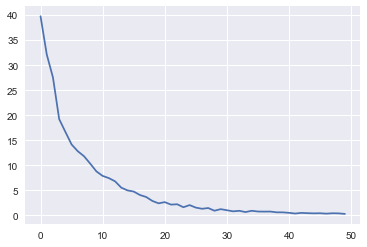

In [137]:
def randomTrainingExample():
    i = random.randint(0,len(training_targets)-1)
    input = input_tprs[training_targets[i][1]]
    morph = morph_embed[training_targets[i][2]]
    target = get_indices(target_tprs[i])
    return input, target, morph

def train(target, input_tpr, morph):
    loss = 0
    hidden = affixer.initHidden()
    affixer.zero_grad()
    output, hidden, affix = affixer(input_tpr, morph, hidden)
    for i in xrange(0, n_role):
        f = torch.matmul(output, U[:,i]).unsqueeze(1)
        sse = torch.sum(torch.pow((F-f), 2), dim=0)
        log_prob = log_softmax(-sse, dim=0) #log probability for filler in role i
        loss = loss + criterion(log_prob.unsqueeze(0), target[i])
        if target.data[i] == 32:
            break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return output, loss[0].data

def timeSince(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

current_loss = 0
all_losses = []
plot_every = 100
print_every = 500

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(affixer.parameters(), lr = learning_rate)

print 'Training in progress:'
start = time.time()
for iter in range(1, n_iters+1):
    input, target, morph = randomTrainingExample()
    output, loss = train(target, input, morph)
    current_loss += loss
    if iter % print_every == 0:
        print '%s (%d %d%%) %.4f' % (timeSince(start), iter, iter/(n_iters/100), loss)
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

plt.show()

## Evaluate the network

The `evaluate` function takes in the input TPR and morphological embedding, and returns the decoded output, decoded affix, hidden states, affix TRP and output TPR.

In [138]:
def evaluate(input_tpr, morph):
    hidden = affixer.initHidden()
    output, hidden, affix = affixer(input_tpr, morph, hidden)
    return decode(output), decode(affix), hidden, affix, output

acc = 0.0
for i in xrange(0,len(target_tprs)):
    out = evaluate(input_tprs[training_targets[i][1]], morph_embed[training_targets[i][2]])[0]
    if decode(target_tprs[i]) == out:
        acc = acc + 1

test_acc = 0.0
for i in xrange(0, len(test_targets)):
    out = evaluate(input_tprs[test_targets[i][1]], morph_embed[test_targets[i][2]])[0]
    print 'target: ' + test_targets[i][0] + '...output: ' + out
    print 'affix: ' + evaluate(input_tprs[test_targets[i][1]], morph_embed[test_targets[i][2]])[1]
    if test_targets[i][0] == out:
        print 'Correct'
        test_acc = test_acc + 1
    print

target: <cantó>...output: <canta>
affix: a>

target: <hablaba>...output: <hablaba>
affix: aba>
Correct

target: <cantare>...output: <cantare>
affix: tre>
Correct

target: <cantar>...output: <cantar>
affix: ar>
Correct

target: <invitado>...output: <invitado>
affix: ado>
Correct

target: <hablan>...output: <hablan>
affix: tno>
Correct

target: <invitaremos>...output: <invitarémos>
affix: arémos>

target: <bailas>...output: <bailas>
affix: as>
Correct

target: <canta>...output: <canta>
affix: ad>
Correct

target: <hablaran>...output: <hablaran>
affix: aran>
Correct

target: <bailaba>...output: <bailaba>
affix: aba>
Correct

target: <invite>...output: <invite>
affix: e>
Correct

target: <canté>...output: <canta>
affix: a>

target: <bailé>...output: <baila>
affix: a>

target: <bailó>...output: <bailó>
affix: a>
Correct

target: <invitemos>...output: <invitemos>
affix: emo>
Correct

target: <cantaran>...output: <cantaran>
affix: aran>
Correct

target: <bailasteis>...output: <bailasteis>
aff

With the current parameter settings, the network is able to learn how to correctly inflect an –ar verb with 80-90% accuracy on both the training and test sets.

In [139]:
print 'Training accuracy: ', acc/len(training_targets)
print 'Test accuracy: ', test_acc/len(test_targets)

Training accuracy:  0.911458333333
Test accuracy:  0.914893617021


By plotting a heatmap of the log probability of each symbol in each position, we can evaluate the network in a different way. Instead of looking just at the symbol with the highest probability, we can see the distribution of probability over all symbols. The darker the orange color, the higher the probability of that symbol. 

Looking at the heatmap below, the symbols at the beginning of the word have probabilities peaked around the correct symbol, but near the end of the word, the probabilities are spread out more evenly among many symbols. This makes sense since the beginning of the word contains the stem, which was given to the network, and the end of the word contains the affix, which was learned by the network and which varies by morphological class. 

In [140]:
label_letters = ['<','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x',
                 'y','z',u'á',u'í',u'é',u'ó',u'ñ','>']

def heatmap(TPR):
    fig, ax = plt.subplots()
    log_prob = Variable(torch.zeros(n_filler,n_role))
    for i in xrange(0, n_role):
        f = torch.matmul(TPR, U[:,i]).unsqueeze(1)
        sse = torch.sum(torch.pow((F-f), 2), dim=0)
        log_prob[:,i] = log_softmax(-sse, dim=0)
    log_prob = np.array(log_prob.data)
    heatmap = sns.heatmap(log_prob, xticklabels=1, yticklabels=1, cbar=False, linewidths=.5, center=0, cmap="Reds")
    heatmap.set_yticklabels(label_letters, rotation=360)
    heatmap.set_title('Target: ' + test_targets[0][0] + '... Output: ' + decode(TPR))
    heatmap.set_ylabel('Filler')
    heatmap.set_xlabel('Role')

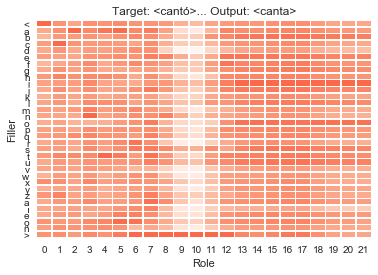

In [141]:
                                                                                #[4]: map output, [3]: map affix
heatmap(evaluate(input_tprs[test_targets[0][1]], morph_embed[test_targets[0][2]])[4])
plt.show()

## Conclusion

In sum, the interpretable model combines what we know from linguistic theory and the computational power and neural plausibility of recurrent neural networks, bridging the canyon between the unique sets of knowledge that linguists and computational modelers have to offer. The interpretable model demonstrates that we do not have to have an either-or distinction between symbolic and continuous or interpretable and computationally powerful. While deep neural networks suffer from being opaque, and symbolic models suffer from a lack of neural plausibility, the interpretable model takes only the best aspects of both frameworks. Having consistent explanations at multiple levels allows for the model to be interpretable, regardless of level of abstraction.